In [9]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    size = vol.shape[1]
    # reshape for labeling
    seg = np.reshape(seg, (size, length*size) )
    vol = np.reshape(vol, (size, length*size) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=-1)
    # shape back
    labeled = np.reshape(labeled, (length, size, size, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i])
    axarr[1,1].imshow(patch.affinity[1][i])
    axarr[1,2].imshow(patch.affinity[2][i])
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
def descend_obj(obj,sep='\t'):
    """
    Iterate through groups in a HDF5 file and prints the groups and datasets names and datasets attributes
    """
    if type(obj) in [h5py._hl.group.Group,h5py._hl.files.File]:
        for key in obj.keys():
            print(sep,'-',key,':',obj[key])
            descend_obj(obj[key],sep=sep+'\t')
    elif type(obj)==h5py._hl.dataset.Dataset:
        for key in obj.attrs.keys():
            print(sep+'\t','-',key,':',obj.attrs[key])

def h5dump(path,group='/'):
    """
    print HDF5 file metadata

    group: you can give a specific group, defaults to the root group
    """
    with h5py.File(path,'r') as f:
         descend_obj(f[group])


h5dump('../../data/sample_C_pad.hdf')

	 - annotations : <HDF5 group "/annotations" (5 members)>
		 - comments : <HDF5 group "/annotations/comments" (2 members)>
			 - comments : <HDF5 dataset "comments": shape (34,), type "|O">
			 - target_ids : <HDF5 dataset "target_ids": shape (34,), type "<u8">
		 - ids : <HDF5 dataset "ids": shape (2230,), type "<u8">
		 - locations : <HDF5 dataset "locations": shape (2230, 3), type "<f4">
		 - presynaptic_site : <HDF5 group "/annotations/presynaptic_site" (1 members)>
			 - partners : <HDF5 dataset "partners": shape (1115, 2), type "<u8">
		 - types : <HDF5 dataset "types": shape (2230,), type "|O">
	 - volumes : <HDF5 group "/volumes" (2 members)>
		 - labels : <HDF5 group "/volumes/labels" (2 members)>
			 - clefts : <HDF5 dataset "clefts": shape (125, 1250, 1250), type "<u8">
					 - offset : [1480. 3644. 3644.]
					 - resolution : [40.  4.  4.]
			 - neuron_ids : <HDF5 dataset "neuron_ids": shape (125, 1250, 1250), type "<u8">
					 - offset : [1480. 3644. 3644.]
					 - resolut

In [68]:
from neutorch.dataset.utils import from_h5
path = '../../data'
fileA = 'sample_A'
fileB = 'sample_B'
fileC = 'sample_C'
imageA = from_h5(f'{path}/{fileA}.hdf', dataset_path='volumes/raw')
imageB = from_h5(f'{path}/{fileB}.hdf', dataset_path='volumes/raw')
imageC = from_h5(f'{path}/{fileC}.hdf', dataset_path='volumes/raw')

In [69]:
size = 180
length = imageA.shape[0]
imageA_small = resize(imageA, (length, size, size))
imageB_small = resize(imageB, (length, size, size))
imageC_small = resize(imageC, (length, size, size))

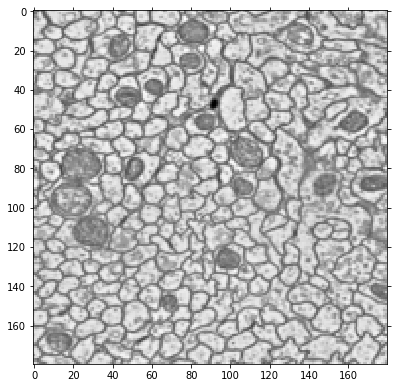

In [70]:
vis_volume(imageA_small)

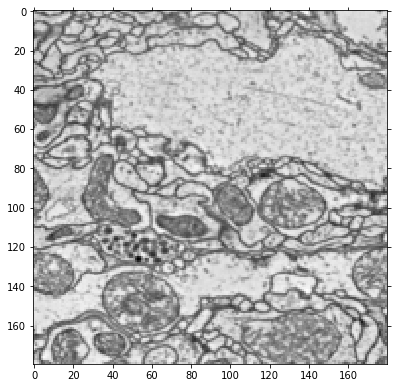

In [74]:
vis_volume(imageB_small)

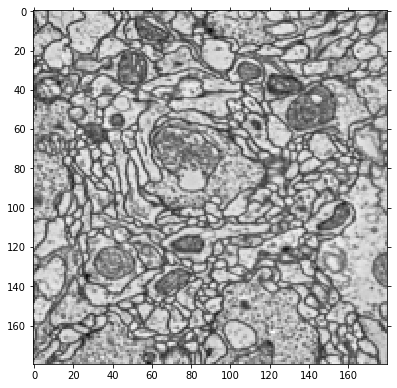

In [73]:
vis_volume(imageC_small)

In [4]:
from neutorch.dataset.affinity import Dataset
from neutorch.dataset.ground_truth_volume import *

dataset = Dataset('../../data', patch_size=(26,256,256), length=100)

loading file sample_A...
loading file sample_B...
loading file sample_C...


KeyboardInterrupt: 

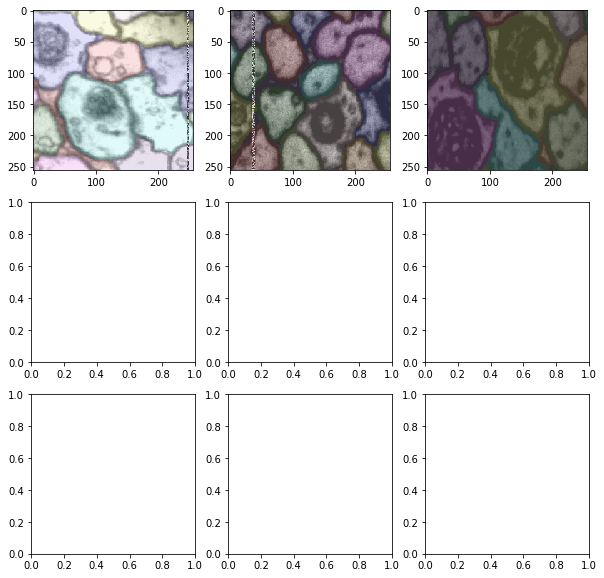

In [4]:
num_plot = 3
i = 0
fig, axarr = plt.subplots(num_plot,num_plot)
fig.set_size_inches(10, 10)

for i in range(num_plot):
    for j in range(num_plot):
        patch = dataset.random_training_patch
        labeled_data = label_data(patch.image[0],patch.label[0])
        axarr[i,j].imshow(labeled_data[i])

[axi.set_axis_off() for axi in axarr.ravel()]
plt.show()

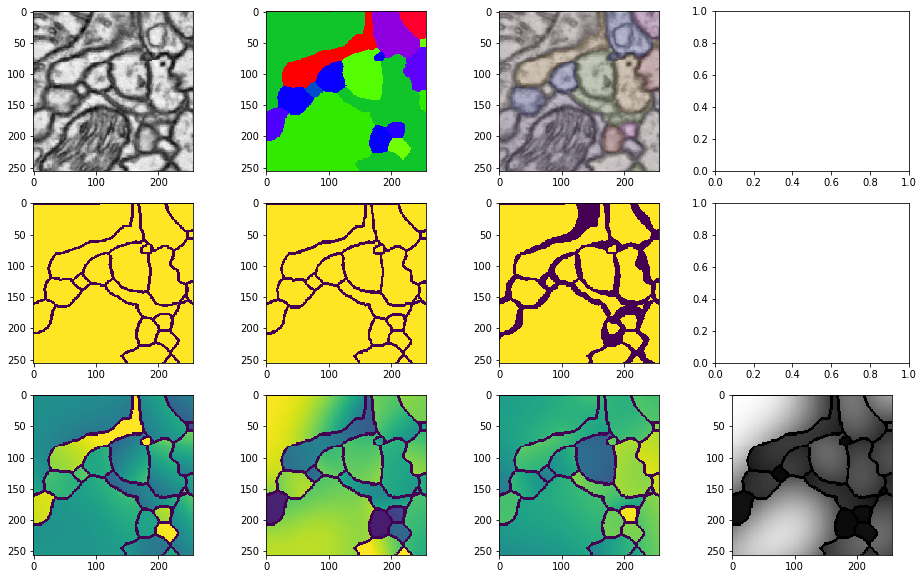

In [7]:
patch = dataset.random_training_patch
view_patch(patch,i=5)

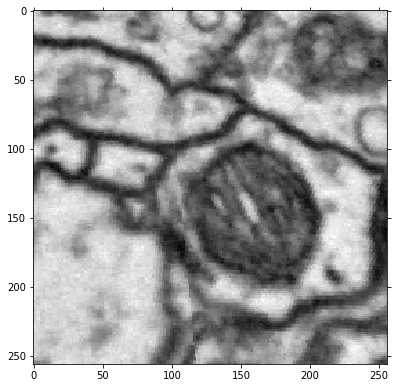

In [154]:
patch = dataset.random_training_patch
vis_volume(np.squeeze(patch.image))

In [2]:
import torchio as tio
from neutorch.dataset.tio_transforms import Brightness

patch = dataset.random_training_patch

brightness = Brightness(amount=(-0.4,0.4))

img = patch.image.copy()

patch.subject = brightness(patch.subject)

i = 4
plt.imshow(img[0,i], cmap='gray')
plt.show()


img2 = patch.image
plt.imshow(img2[0,i], cmap='gray')
plt.show()

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



NameError: name 'dataset' is not defined

In [80]:
import numpy as np

affinity = np.load('../../preds/affinity.npy')

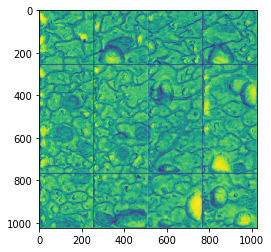

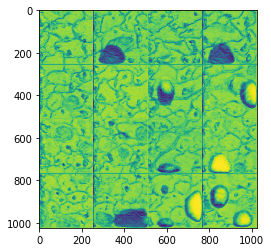

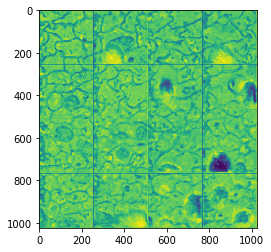

In [84]:
i = 5

plt.imshow(affinity[0][i])
plt.show()
plt.imshow(affinity[1][i])
plt.show()
plt.imshow(affinity[2][i])
plt.show()